In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, v_measure_score, mean_squared_error
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM , Dropout
import tensorflow as tf 

from fbprophet import Prophet
from sklearn.metrics import explained_variance_score, r2_score

LOOK_BACK = 7
BASE_DIR = "/content/"
START_DATE = "2017-01-01"
DUE_DATE = "2022-03-30"

# **Bitcoin daily Data**

In [4]:
def get_bitcoin_candlestick(start_date, end_date):
    """  get bitcoin daily info from yahooFinance and remove non values"""

    btc_df = yf.download("BTC-USD", start_date, end_date,
                         auto_adjust=True)

    btc_df['daily_return'] = (btc_df['Close'] -
                                  btc_df['Open']) / btc_df['Open']

    btc_df = btc_df.dropna()

    return btc_df


btc_df = get_bitcoin_candlestick(start_date=START_DATE , end_date=DUE_DATE)
btc_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,daily_return
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0.035974
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023165
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021770
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.105640
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.123927


In [9]:
def plot_bitcoin_daily_candlestick(btc_df, length):

    fig = go.Figure(data=[go.Candlestick(
            x=btc_df.index,
            open=btc_df.iloc[-length:]['Open'],
            high=btc_df.iloc[-length:]['High'],
            low=btc_df.iloc[-length:]['Low'],
            close=btc_df.iloc[-length:]['Close'])])

    fig.update_layout(
        width=900,
        height=450,
        title=dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
        yaxis_title=dict(text='Price (USD)', font=dict(size=15)),
        margin=dict(l=10, r=20, t=80, b=20)
    )

    fig.show()


plot_bitcoin_daily_candlestick(btc_df, 100)

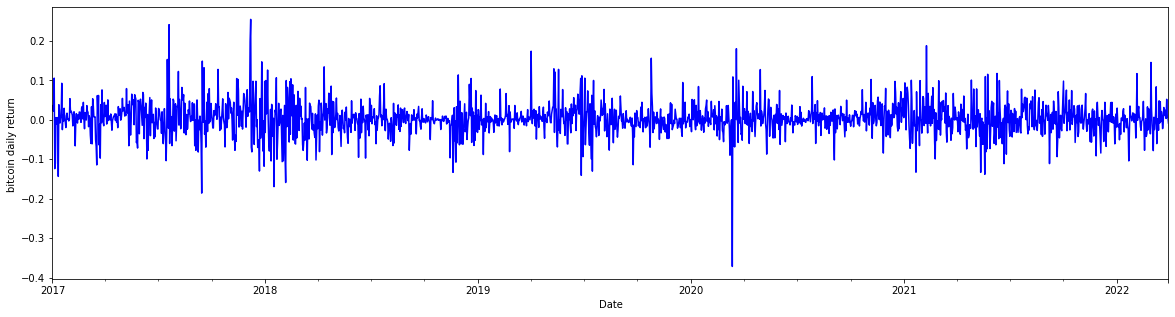

In [10]:

# Plot the daily return
btc_df.btc_daily_return.plot(figsize=(20, 5), color='b')
plt.ylabel("bitcoin daily return ")
plt.show()

# **correlation analysis**

[*********************100%***********************]  1 of 1 completed


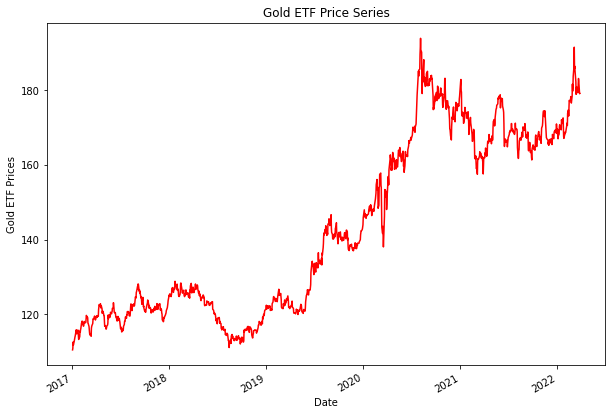

[*********************100%***********************]  1 of 1 completed


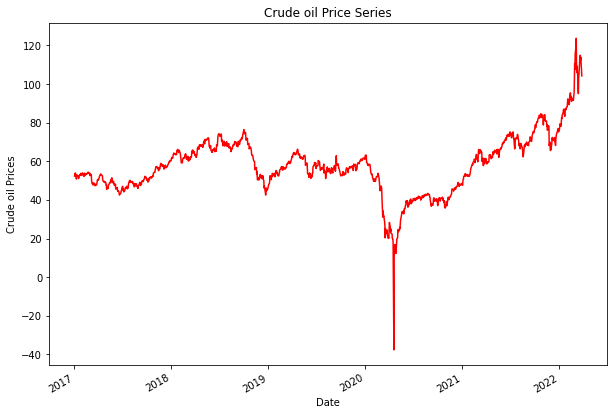

In [11]:


def get_gold_candlestick(start_date, end_date):

    """ get gold daily prices and calculate daily return """

    gold_df = yf.download('GLD', start_date, end_date, auto_adjust=True)

    gold_df = gold_df.dropna()

    gold_df['gold_daily_return'] = (gold_df['Close'] -
                                    gold_df['Open']) / gold_df['Open']

    # Plot the closing price of GLD
    gold_df.Close.plot(figsize=(10, 7), color='r')
    plt.ylabel("Gold ETF Prices")
    plt.title("Gold ETF Price Series")
    plt.show()

    return gold_df


def get_crude_oil_candlestick(start_date, end_date):

    """ get crude oil daily prices and calculate daily return """

    oil_df = yf.download('CL=F', start_date, end_date, auto_adjust=True)
    oil_df = oil_df.dropna()

    oil_df['oil_daily_return'] = (oil_df['Close'] -
                                  oil_df['Open']) / oil_df['Open']

    # Plot the closing price of crude oil
    oil_df.Close.plot(figsize=(10, 7), color='r')
    plt.ylabel("Crude oil Prices")
    plt.title("Crude oil Price Series")
    plt.show()

    return oil_df

gold_df = get_gold_candlestick(start_date= START_DATE ,end_date= DUE_DATE)
oil_df = get_crude_oil_candlestick(start_date=START_DATE ,end_date= DUE_DATE)

# **correlation analyze**

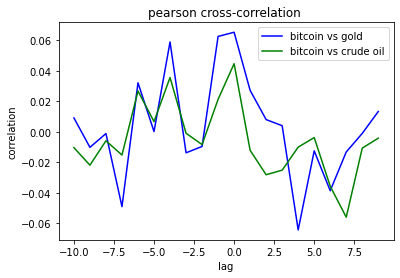

In [12]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. """

    return datax.corr(datay.shift(lag), method=method)


def check_correlation_lags(pos_lag, neg_lag, corr_method):

    btc_returns = btc_df['btc_daily_return']
    oil_returns = oil_df['oil_daily_return']
    gold_returns = gold_df['gold_daily_return']

    df = pd.merge(btc_returns, oil_returns, left_index=True, right_index=True)
    df = pd.merge(df, gold_returns, left_index=True, right_index=True)

    gold_cov = [crosscorr(df['btc_daily_return'], df['gold_daily_return'],
                          lag=i, method=corr_method) for i in range(-neg_lag, pos_lag)]
    oil_cov = [crosscorr(df['btc_daily_return'], df['oil_daily_return'],
                         lag=i, method=corr_method) for i in range(-neg_lag, pos_lag)]

    plt.plot(range(-neg_lag, pos_lag), gold_cov, color='blue',
             label="bitcoin vs gold")
    plt.plot(range(-neg_lag, pos_lag), oil_cov, color='green',
             label='bitcoin vs crude oil')
    plt.title(corr_method + " cross-correlation ")
    plt.xlabel("lag")
    plt.ylabel("correlation")
    plt.legend()
    plt.show()


check_correlation_lags(pos_lag=10, neg_lag=10, corr_method="pearson")

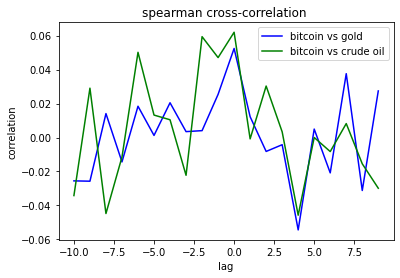

In [13]:
check_correlation_lags(pos_lag=10, neg_lag=10, corr_method="spearman")

# bitcoin daily return prediction with LSTM

In [12]:

def train_test_split(train_length , df ):
    """Normalize date column and split into train and test sets """

    
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[['daily_return']])
    btc_daily_return_data = scaler.transform(df[['daily_return']])

    btc_daily_return = pd.DataFrame(btc_daily_return_data ,columns= ['daily_return'] , index=df.index )

    train_size = int(len(btc_daily_return) * train_length)
    test_size = len(btc_daily_return) - train_size
    train = btc_daily_return[0:train_size]
    test = btc_daily_return[train_size:len(btc_daily_return)]

    return train, test

def create_dataset(X, y, time_steps=1):
    """ reshape data to [samples, time_steps, n_features] """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

btc_df = get_bitcoin_candlestick(start_date="2018-01-01",end_date="2022-03-30")

train, test = train_test_split(train_length=0.7 , df =btc_df )
X_train, y_train = create_dataset(train, train.daily_return, LOOK_BACK)
X_test, y_test = create_dataset(test, test.daily_return, LOOK_BACK)


[*********************100%***********************]  1 of 1 completed


Epoch 1/300
27/27 [==============================] - 4s 43ms/step - loss: 1.0772 - val_loss: 0.4818
Epoch 2/300
27/27 [==============================] - 1s 19ms/step - loss: 1.0708 - val_loss: 0.4840
Epoch 3/300
27/27 [==============================] - 1s 20ms/step - loss: 1.0683 - val_loss: 0.4836
Epoch 4/300
27/27 [==============================] - 1s 35ms/step - loss: 1.0657 - val_loss: 0.4841
Epoch 5/300
27/27 [==============================] - 1s 23ms/step - loss: 1.0598 - val_loss: 0.4860
Epoch 6/300
27/27 [==============================] - 0s 14ms/step - loss: 1.0379 - val_loss: 0.4841
Epoch 7/300
27/27 [==============================] - 0s 16ms/step - loss: 1.0475 - val_loss: 0.4884
Epoch 8/300
27/27 [==============================] - 0s 15ms/step - loss: 1.0705 - val_loss: 0.4798
Epoch 9/300
27/27 [==============================] - 0s 17ms/step - loss: 1.0613 - val_loss: 0.4813
Epoch 10/300
27/27 [==============================] - 0s 14ms/step - loss: 1.0563 - val_loss: 0.4829

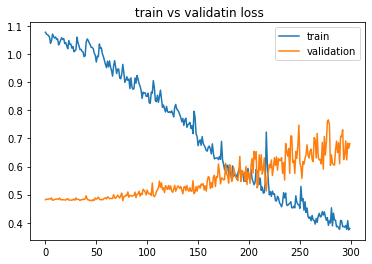

In [13]:
def btc_return_LSTM_prediction(Xtrain, ytrain, Xtest, ytest, epoch_num):

    # callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    model = Sequential()
    model.add(LSTM(units=128, activation='relu',
                   input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=10))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

    history = model.fit(Xtrain, ytrain, epochs=epoch_num,
                        batch_size=32,
                        # callbacks=[callback],
                        validation_split=0.2,
                        verbose=1,
                        shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(" train vs validatin loss")
    plt.legend()

    return model


lstm_model = btc_return_LSTM_prediction(Xtrain=X_train, ytrain=y_train,
                                        Xtest=X_test, ytest=y_test, epoch_num=300)

 MSE of LSTM model on test data 
1.3542432970490514


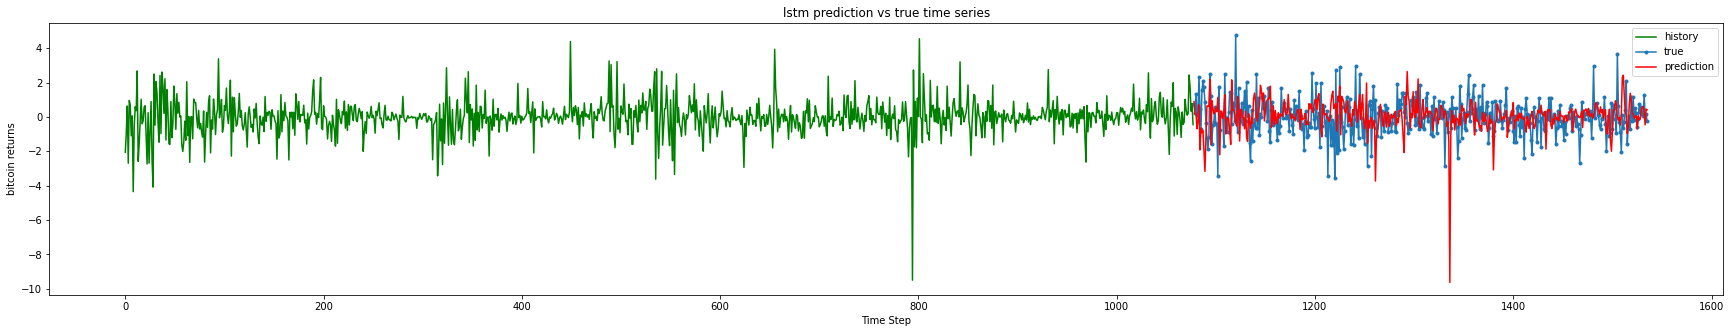

In [15]:
def evalute_LSTM_model(model):

    y_pred = model.predict(X_test)

    print(" MSE of LSTM model on test data ")
    print(np.sqrt(mean_squared_error(y_test, y_pred)))

    plt.figure(figsize=(30, 5))
    plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
             y_test, marker='.', label="true")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
             y_pred, 'r', label="prediction")
    plt.ylabel('bitcoin returns')
    plt.xlabel('Time Step')
    plt.title('lstm prediction vs true time series')
    plt.legend()
    plt.show()


evalute_LSTM_model(lstm_model)

# **predict bitcoin Open price with Prophet model and onchain features**

In [16]:
btc = pd.read_csv(os.path.join(BASE_DIR, "BTC-USD_full.csv"))
btc["Date"] = pd.to_datetime(btc["Date"], format="%Y-%m-%d")

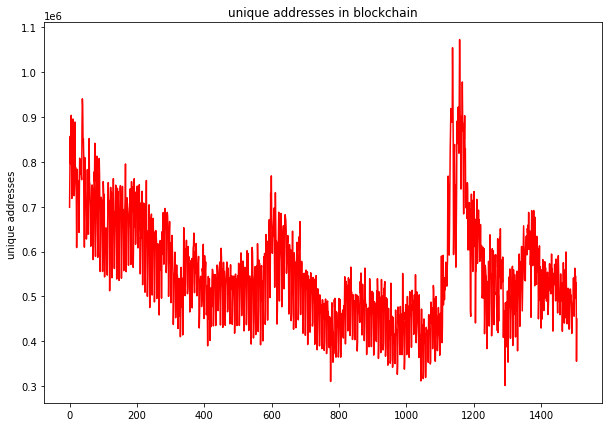

In [17]:
# unique addresses

addresses = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-NADDU.csv"))
addresses["Date"] = pd.to_datetime(addresses["Date"], format="%Y-%m-%d")
addresses = addresses.loc[addresses["Date"] >= START_DATE]

addresses.Addresses.plot(figsize=(10, 7), color='r')
plt.ylabel("unique addresses ")
plt.title("unique addresses in blockchain")
plt.show()

In [18]:
# difficulty
difficulty = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-DIFF.csv"))
difficulty["Date"] = pd.to_datetime(difficulty["Date"], format="%Y-%m-%d")
difficulty = difficulty.loc[difficulty["Date"] >= START_DATE]

In [19]:
# hashrate
hashrate = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-HRATE.csv"))
hashrate["Date"] = pd.to_datetime(hashrate["Date"], format="%Y-%m-%d")
hashrate = hashrate.loc[hashrate["Date"] >= START_DATE]

In [20]:
# total bitcoins
total_bitcoins = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-TOTBC.csv"))
total_bitcoins["Date"] = pd.to_datetime(total_bitcoins["Date"], format="%Y-%m-%d")
total_bitcoins = total_bitcoins.loc[total_bitcoins["Date"] >= START_DATE]

In [21]:
# transactions excluding popular addresses
xpopular_addresses = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-NTREP.csv"))
xpopular_addresses["Date"] = pd.to_datetime(xpopular_addresses["Date"], format="%Y-%m-%d")
xpopular_addresses = xpopular_addresses.loc[xpopular_addresses["Date"] >= START_DATE]

In [22]:
# average block size in MB
average_block_size = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-AVBLS.csv"))
average_block_size["Date"] = pd.to_datetime(average_block_size["Date"], format="%Y-%m-%d")
average_block_size = average_block_size.loc[average_block_size["Date"] >= START_DATE]

In [23]:
len(average_block_size)

1507

In [36]:
# S&P 500
snp500 = pd.read_csv(os.path.join(BASE_DIR, "S&P500.csv"))
snp500["Date"] = pd.to_datetime(snp500["Date"], format="%Y-%m-%d")
snp500 = snp500.loc[snp500["Date"] >= START_DATE]
snp500 = snp500[["Date", "Close"]]
snp500 = snp500.rename(columns={"Date": "Date", "Open": "SnP500"})

In [37]:
# 13 Week Treasury Bill
t_bill = pd.read_csv(os.path.join(BASE_DIR, "IRX.csv"))
t_bill["Date"] = pd.to_datetime(t_bill["Date"], format="%Y-%m-%d")
t_bill = t_bill.loc[t_bill["Date"] >= START_DATE]
t_bill = t_bill[["Date", "Open"]]
t_bill = t_bill.rename(columns={"Date": "Date", "Open": "TBill"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


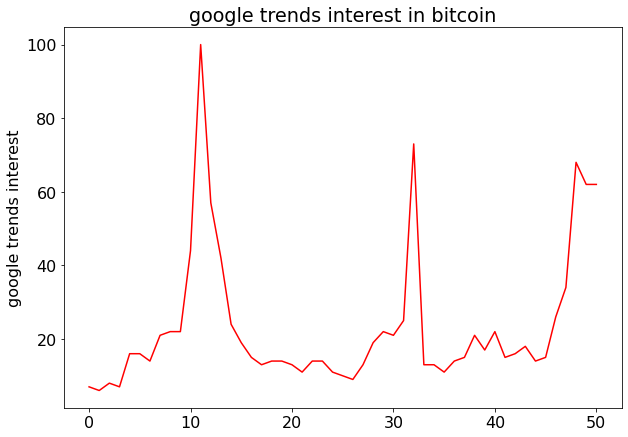

In [38]:
# Google Trends worldwide sentiment about Bitcoin (Topic)

def clean_google_trends_data(df, start_date, max_date):
    trends = df.copy()
    trends["Date"] = pd.to_datetime(trends["Month"], format="%Y-%m")
    trends.drop("Month", axis=1, inplace=True)

    # ensure maximum date matches up with price data
    trends = trends.loc[trends["Date"] >= start_date]
    trends = pd.concat(
        [trends, pd.DataFrame(data={"Date": [max_date], "Interest": [np.NaN]})],
        ignore_index=True,
    )

    # perform linear interpolation
    trends = trends.set_index("Date")
    trends = trends.interpolate()
    trends = trends.reset_index()
    return trends


google_trends_sentiment = pd.read_csv(os.path.join(BASE_DIR, "Google_BTC_interest.csv"))
google_trends_sentiment = clean_google_trends_data(google_trends_sentiment, START_DATE, DUE_DATE)

google_trends_sentiment.Interest.plot(figsize=(10, 7), color='r')
plt.ylabel("google trends interest")
plt.title("google trends interest in bitcoin")
plt.show()

In [27]:
additional_regressors = [
    addresses,
    difficulty,
    hashrate,
    total_bitcoins,
    snp500,
    t_bill,
    xpopular_addresses,
    average_block_size,
    google_trends_sentiment,
]

btc_features = btc[["Date", "Open"]]
for regressor in additional_regressors:
    btc_features = btc_features.merge(regressor, on="Date")
btc_features.dropna(inplace=True)


## bitcoin opening price prediction with prophet

In [28]:
def calculate_performance_metrics(y_true, y_predicted):
    r2 = r2_score(y_true, y_predicted)
    rmse = mean_squared_error(y_true, y_predicted, squared=False)
    print(f"R2 score: {r2}")
    print(f"RMSE: {rmse}")
    
    
def set_nonnegative_forecasts(forecast):
    forecast.loc[forecast["yhat"] < 0, "yhat"] = 0
    forecast.loc[forecast["yhat_lower"] < 0, "yhat_lower"] = 0
    forecast.loc[forecast["yhat_upper"] < 0, "yhat_upper"] = 0    


In [29]:
PREDICTION_CUTOFF = "2021-01-01"

input_df = btc_features[["Date", "Open"]]
# column name remapping for Prophet
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [30]:
init_model = Prophet(
    daily_seasonality=False, 
    seasonality_mode="multiplicative"
)
init_model.fit(input_df)
train_forecast = init_model.predict(input_df)
set_nonnegative_forecasts(train_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


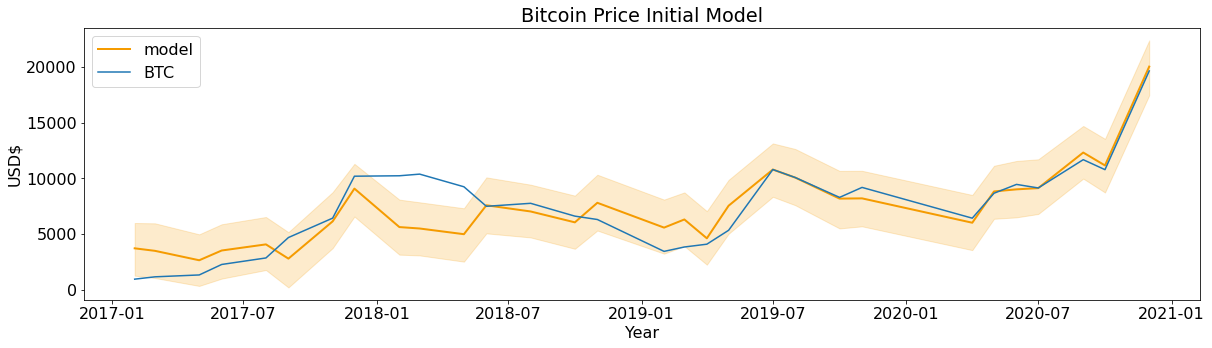

In [33]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots(figsize=(20,5));
ax.plot(train_forecast["ds"], train_forecast["yhat"], linewidth=2, color="#F59B00", label="model" )
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.fill_between(train_forecast["ds"], train_forecast["yhat_lower"], train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Bitcoin Price Initial Model");
plt.legend();

In [34]:
forecast_init = init_model.predict(future_df)
print("Metrics on test set")
calculate_performance_metrics(forecast_init.loc[:, "yhat"], future_df["y"])

Metrics on test set
R2 score: nan
RMSE: 14360.600594848169


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# with regressors

In [40]:
input_df = btc_features[
    [
        "Date", 
        "Open", 
        "Addresses", 
        "Difficulty", 
        "Hash_Rate", 
        "Total_Bitcoins", 
        # "SnP500", 
        "TBill", 
        "Transactions_Excluding_Popular",
        "Average_Block_Size_MB",
        "Interest",
    ]
]
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
    "Addresses": "addresses",
    "Difficulty": "difficulty",
    "Hash_Rate": "hash_rate",
    "Total_Bitcoins": "total_bitcoins",
    "SnP500": "snp500",
    "TBill": "t_bill",
    "Transactions_Excluding_Popular": "transactions_excluding_popular",
    "Average_Block_Size_MB": "average_block_size_mb",
    "Interest": "interest",
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [41]:
extended_model = Prophet(
    daily_seasonality=False, 
    seasonality_mode="multiplicative"
)

for col in input_df.columns:
    if col not in ["ds", "y"]:
        extended_model.add_regressor(col, mode="additive")

extended_model.fit(input_df);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [42]:
train_forecast = extended_model.predict(input_df)
set_nonnegative_forecasts(train_forecast)

In [43]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
R2 score: 0.9995035761858001
RMSE: 86.88702805076124


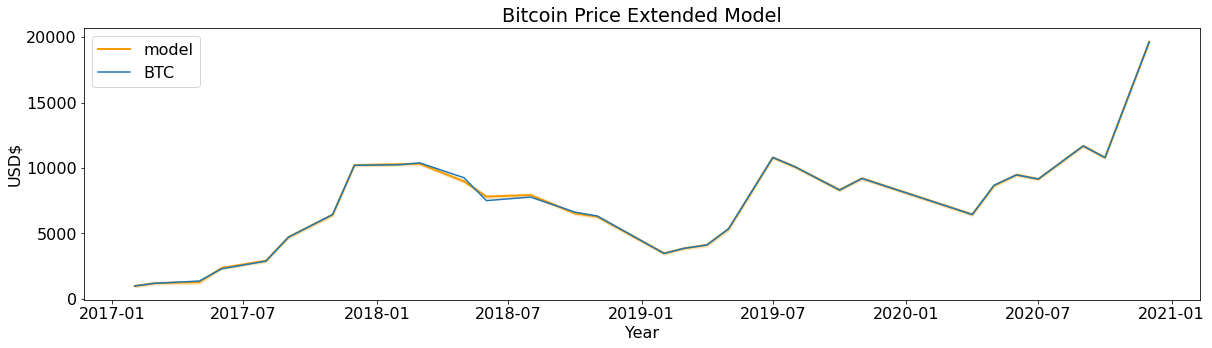

In [45]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots(figsize=(20,5));
ax.plot(train_forecast["ds"], train_forecast["yhat"], linewidth=2, color="#F59B00", label="model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.fill_between(train_forecast["ds"], train_forecast["yhat_lower"], train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Bitcoin Price Extended Model");
plt.legend();

In [46]:
forecast = extended_model.predict(future_df)
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
R2 score: nan
RMSE: 32513.858974692306


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
